# [E-06] Naver_Moviereview_setimentanalysis

## 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tensorflow import keras
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 준비와 확인

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print('훈련용 리뷰 개수 :', len(train_data) )

훈련용 리뷰 개수 : 150000


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print('테스트용 리뷰 개수 :', len(test_data) )

테스트용 리뷰 개수 : 50000


## 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

document 열과 label 열의 중복을 제외한 값의 개수

In [6]:
train_data['document'].nunique(),train_data['label'].nunique()

(146182, 2)

In [7]:
test_data['document'].nunique(),test_data['label'].nunique()

(49157, 2)

In [8]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)   # 중복 제거
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    


In [9]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


숫자:단어인 딕셔너리 index_to_word를 생성한다

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}

- get_encoded_sentence : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
- get_encoded_sentences : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
- get_decoded_sentence : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수  
- get_decoded_sentences : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로decode하는 함수

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [12]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## pading적용 
(post와 pre 적용)

In [14]:
X_train_pre = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train_pre.shape)
print(X_test_pre.shape)

(146182, 41)
(49157, 41)


In [15]:
X_train_post = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

X_test_post = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=maxlen)

print(X_train_post.shape)
print(X_test_post.shape)

(146182, 41)
(49157, 41)


In [16]:
print(X_train_pre[0])
print(get_decoded_sentence(X_train_pre[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [17]:
print(X_train_post[0])
print(get_decoded_sentence(X_train_post[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
더 빙 . . 진짜 짜증 나 네요 목소리 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
라벨:  0


## 4) 모델 구성 및 validation set 구성

In [18]:
# validation set 10000건 분리
X_val_pre = X_train_pre[:45000]    # pre 패딩된 train set 분리
X_val_post = X_train_post[:45000]  # post 패딩된 train set 분리
y_val = y_train[:45000]

# validation set을 제외한 나머지
partial_X_train_pre = X_train_pre[45000:]
partial_X_train_post = X_train_post[45000:]
partial_y_train = y_train[45000:]


# validation set 갯수
print(X_val_pre.shape)
print(X_val_post.shape)
print(y_val.shape)

# 나머지 train set 갯수
print(partial_X_train_pre.shape)
print(partial_X_train_post.shape)
print(partial_y_train.shape)

(45000, 41)
(45000, 41)
(45000,)
(101182, 41)
(101182, 41)
(101182,)


## 모델
- RNN
- 1-D CNN
- GlobalMaxPooling1D

## RNN

In [19]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_pre = keras.Sequential()
model_rnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_pre.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_rnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_pre.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [20]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# LSTM 레이어로 모델 설계
model_rnn_post = keras.Sequential()
model_rnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn_post.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수 (변경가능)
model_rnn_post.add(keras.layers.Dense(8, activation='relu'))
model_rnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_rnn_post.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## 1-D CNN

In [21]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_pre = keras.Sequential()
model_1dcnn_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.MaxPooling1D(5))
model_1dcnn_pre.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_pre.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_pre.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [22]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# 1-D CNN 모델 설계
model_1dcnn_post = keras.Sequential()
model_1dcnn_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.MaxPooling1D(5))
model_1dcnn_post.add(keras.layers.Conv1D(16, 3, activation='relu'))
model_1dcnn_post.add(keras.layers.GlobalMaxPooling1D())
model_1dcnn_post.add(keras.layers.Dense(8, activation='relu'))
model_1dcnn_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_1dcnn_post.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

## GlobalMaxPooling1D

In [23]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_pre = keras.Sequential()
model_gmp_pre.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_pre.add(keras.layers.GlobalMaxPooling1D())
model_gmp_pre.add(keras.layers.Dense(8, activation='relu'))
model_gmp_pre.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_pre.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [24]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)

# GlobalMaxPooling1D() 레이어 하나만 사용하여 모델 설계
model_gmp_post = keras.Sequential()
model_gmp_post.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp_post.add(keras.layers.GlobalMaxPooling1D())
model_gmp_post.add(keras.layers.Dense(8, activation='relu'))
model_gmp_post.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_gmp_post.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

### RNN 모델 훈련 pre, post

In [25]:
model_rnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_pre = model_rnn_pre.fit(partial_X_train_pre,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_pre, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 21s 8ms/step - loss: 0.5436 - accuracy: 0.7351 - val_loss: 0.3901 - val_accuracy: 0.8415
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3528 - accuracy: 0.8534 - val_loss: 0.3522 - val_accuracy: 0.8492
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3199 - accuracy: 0.8676 - val_loss: 0.3555 - val_accuracy: 0.8469
Epoch 4/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3041 - accuracy: 0.8750 - val_loss: 0.3495 - val_accuracy: 0.8486
Epoch 5/5
198/198 [==============================] - 1s 6ms/step - loss: 0.2927 - accuracy: 0.8804 - val_loss: 0.3536 - val_accuracy: 0.8488


In [26]:
model_rnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_rnn_post = model_rnn_post.fit(partial_X_train_post,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val_post, y_val),
                    verbose=1)

Epoch 1/5
198/198 [==============================] - 3s 8ms/step - loss: 0.5884 - accuracy: 0.6950 - val_loss: 0.4474 - val_accuracy: 0.8328
Epoch 2/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3778 - accuracy: 0.8475 - val_loss: 0.3623 - val_accuracy: 0.8458
Epoch 3/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.8635 - val_loss: 0.3557 - val_accuracy: 0.8475
Epoch 4/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3132 - accuracy: 0.8715 - val_loss: 0.3577 - val_accuracy: 0.8454
Epoch 5/5
198/198 [==============================] - 1s 6ms/step - loss: 0.3025 - accuracy: 0.8763 - val_loss: 0.3646 - val_accuracy: 0.8427


## 1-D CNN 모델 훈련 pre, post 

In [27]:
model_1dcnn_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_pre = model_1dcnn_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 15s 15ms/step - loss: 0.5899 - accuracy: 0.6744 - val_loss: 0.4742 - val_accuracy: 0.7589
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4429 - accuracy: 0.7824 - val_loss: 0.4597 - val_accuracy: 0.7682
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.4074 - accuracy: 0.8022 - val_loss: 0.4638 - val_accuracy: 0.7660
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3817 - accuracy: 0.8179 - val_loss: 0.4736 - val_accuracy: 0.7687
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3572 - accuracy: 0.8315 - val_loss: 0.4876 - val_accuracy: 0.7653


In [28]:
model_1dcnn_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_1dcnn_post = model_1dcnn_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 2s 6ms/step - loss: 0.5281 - accuracy: 0.7375 - val_loss: 0.3678 - val_accuracy: 0.8403
Epoch 2/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3394 - accuracy: 0.8557 - val_loss: 0.3466 - val_accuracy: 0.8494
Epoch 3/5
198/198 [==============================] - 1s 5ms/step - loss: 0.3002 - accuracy: 0.8757 - val_loss: 0.3467 - val_accuracy: 0.8514
Epoch 4/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2725 - accuracy: 0.8891 - val_loss: 0.3507 - val_accuracy: 0.8508
Epoch 5/5
198/198 [==============================] - 1s 5ms/step - loss: 0.2461 - accuracy: 0.9022 - val_loss: 0.3587 - val_accuracy: 0.8504


## GlobalMaxPooling1D 모델 훈련 pre,post

In [29]:
model_gmp_pre.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_pre = model_gmp_pre.fit(partial_X_train_pre,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_pre, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 1s 4ms/step - loss: 0.6296 - accuracy: 0.7424 - val_loss: 0.5041 - val_accuracy: 0.7968
Epoch 2/5
198/198 [==============================] - 1s 4ms/step - loss: 0.4129 - accuracy: 0.8267 - val_loss: 0.3743 - val_accuracy: 0.8361
Epoch 3/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3416 - accuracy: 0.8559 - val_loss: 0.3574 - val_accuracy: 0.8434
Epoch 4/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3099 - accuracy: 0.8706 - val_loss: 0.3541 - val_accuracy: 0.8454
Epoch 5/5
198/198 [==============================] - 1s 4ms/step - loss: 0.2867 - accuracy: 0.8817 - val_loss: 0.3565 - val_accuracy: 0.8456


In [30]:
model_gmp_post.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history_gmp_post = model_gmp_post.fit(partial_X_train_post,
                                       partial_y_train,
                                       epochs=epochs,
                                       batch_size=512,
                                       validation_data=(X_val_post, y_val),
                                       verbose=1)

Epoch 1/5
198/198 [==============================] - 1s 4ms/step - loss: 0.6097 - accuracy: 0.7183 - val_loss: 0.4916 - val_accuracy: 0.8067
Epoch 2/5
198/198 [==============================] - 1s 4ms/step - loss: 0.4247 - accuracy: 0.8305 - val_loss: 0.3885 - val_accuracy: 0.8354
Epoch 3/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3484 - accuracy: 0.8578 - val_loss: 0.3621 - val_accuracy: 0.8438
Epoch 4/5
198/198 [==============================] - 1s 4ms/step - loss: 0.3100 - accuracy: 0.8743 - val_loss: 0.3562 - val_accuracy: 0.8460
Epoch 5/5
198/198 [==============================] - 1s 4ms/step - loss: 0.2834 - accuracy: 0.8863 - val_loss: 0.3592 - val_accuracy: 0.8466


##  6) Loss, Accuracy 그래프 시각화

## RNN 모델 pre, post

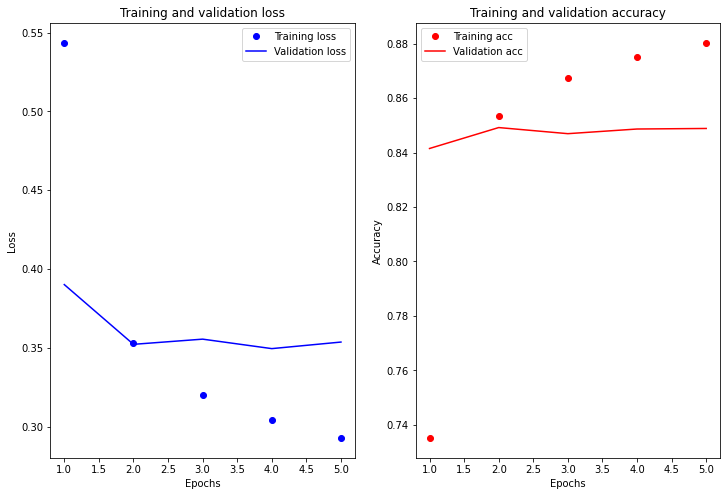

In [31]:
history_rnn_pre_dict = history_rnn_pre.history

acc = history_rnn_pre_dict['accuracy']
val_acc = history_rnn_pre_dict['val_accuracy']
loss = history_rnn_pre_dict['loss']
val_loss = history_rnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

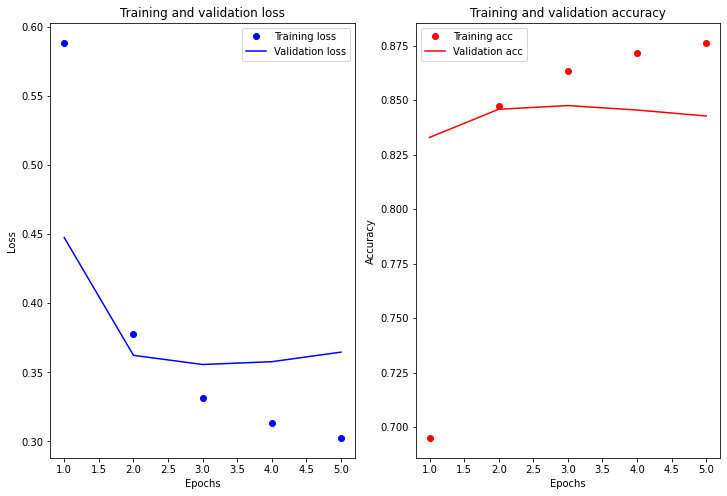

In [32]:
history_rnn_post_dict = history_rnn_post.history

acc = history_rnn_post_dict['accuracy']
val_acc = history_rnn_post_dict['val_accuracy']
loss = history_rnn_post_dict['loss']
val_loss = history_rnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 1-D CNN 모델 pre, post

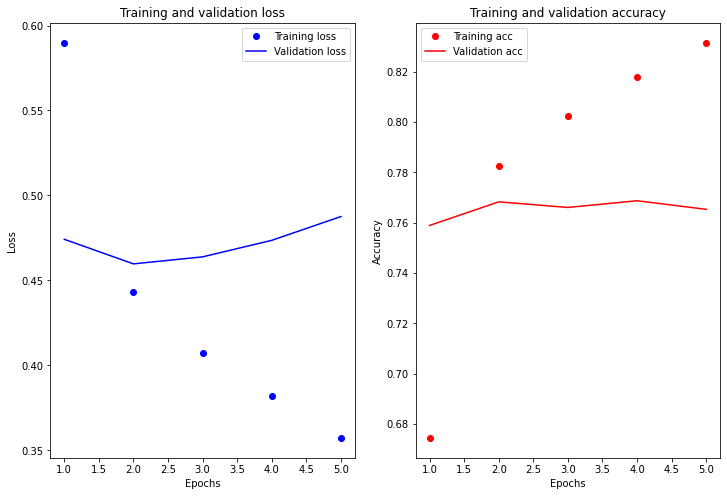

In [33]:
history_1dcnn_pre_dict = history_1dcnn_pre.history

acc = history_1dcnn_pre_dict['accuracy']
val_acc = history_1dcnn_pre_dict['val_accuracy']
loss = history_1dcnn_pre_dict['loss']
val_loss = history_1dcnn_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

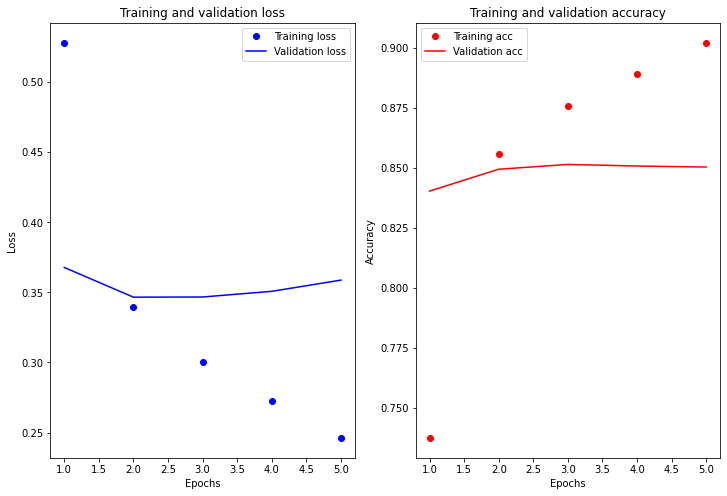

In [34]:
history_1dcnn_post_dict = history_1dcnn_post.history

acc = history_1dcnn_post_dict['accuracy']
val_acc = history_1dcnn_post_dict['val_accuracy']
loss = history_1dcnn_post_dict['loss']
val_loss = history_1dcnn_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## GlobalMaxPooling1D 모델 pre, post

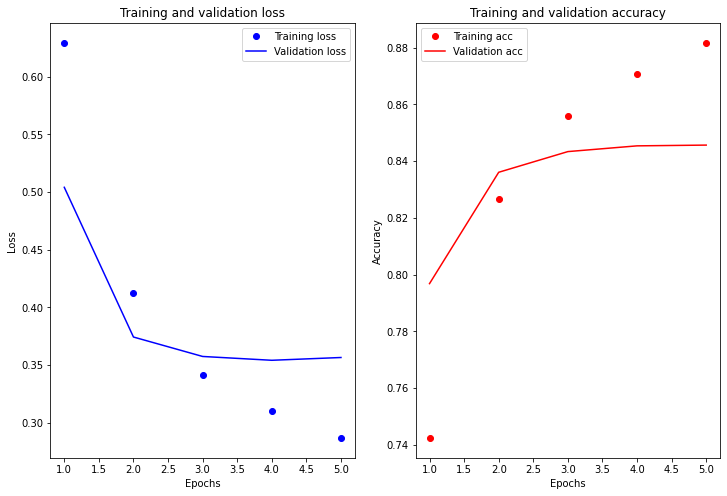

In [35]:
history_gmp_pre_dict = history_gmp_pre.history

acc = history_gmp_pre_dict['accuracy']
val_acc = history_gmp_pre_dict['val_accuracy']
loss = history_gmp_pre_dict['loss']
val_loss = history_gmp_pre_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

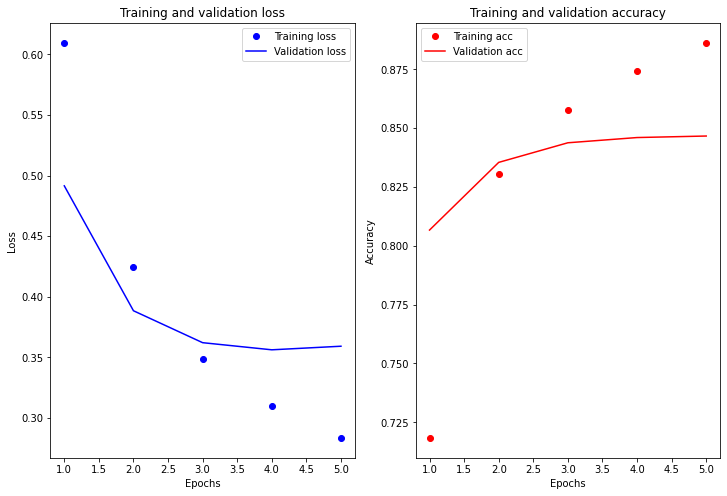

In [36]:
history_gmp_post_dict = history_gmp_post.history

acc = history_gmp_post_dict['accuracy']
val_acc = history_gmp_post_dict['val_accuracy']
loss = history_gmp_post_dict['loss']
val_loss = history_gmp_post_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
rnn_pre_accuray = history_rnn_pre_dict['accuracy'][4]
rnn_pre_accuray

0.8803542256355286

In [38]:
rnn_post_accuray = history_rnn_post_dict['accuracy'][4]
rnn_post_accuray

0.8763120174407959

In [39]:
_1dcnn_pre_accuray = history_1dcnn_pre_dict['accuracy'][4]
_1dcnn_pre_accuray 

0.8315016627311707

In [40]:
_1dcnn_post_accuray = history_1dcnn_post_dict['accuracy'][4]
_1dcnn_post_accuray 

0.9021565318107605

In [41]:
gmp_pre_accuray = history_gmp_pre_dict['accuracy'][4]
gmp_pre_accuray

0.8817378878593445

In [42]:
gmp_post_accuray = history_gmp_post_dict['accuracy'][4]
gmp_post_accuray

0.8863039016723633

가장 정확도가 높은거는 RNN 모델 pre padding을 했을 때가 가장 높았다.
RNN에선 pre padding이 높았고 1-DCNN은 post padding했을 때가 높았고, GMP는 결과는 비슷했다.

## 7) 학습된 Embedding 레이어 분석

In [43]:
embedding_layer = model_rnn_pre.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_rnn_pre.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("행복")

[('발킬머', 0.9746788740158081),
 ('살아가', 0.9706574082374573),
 ('강렬', 0.9685230851173401),
 ('이럼', 0.9620318412780762),
 ('하나하나', 0.9601463675498962),
 ('느껴져서', 0.9552302360534668),
 ('자료', 0.9532776474952698),
 ('감탄', 0.9520677328109741),
 ('즐거웠', 0.950090765953064),
 ('설레', 0.9498065114021301)]

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('보너스', 0.9705959558486938),
 ('낸', 0.9691668748855591),
 ('쪼', 0.9664044380187988),
 ('이준기', 0.9647164940834045),
 ('찔끔', 0.9627871513366699),
 ('설레', 0.962218701839447),
 ('금요일', 0.9602018594741821),
 ('구할', 0.9585897922515869),
 ('장수', 0.9582747220993042),
 ('통쾌', 0.9580087065696716)]

In [47]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("안녕")

[('억', 0.9532925486564636),
 ('추격자', 0.9514153003692627),
 ('학예회', 0.9490431547164917),
 ('눈썹', 0.9450027346611023),
 ('반열', 0.9448840618133545),
 ('다투', 0.944004237651825),
 ('구경', 0.9422540664672852),
 ('류급', 0.942049503326416),
 ('봐선', 0.9416708946228027),
 ('답습', 0.940500020980835)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [48]:
!pip install gensim==3.8.3

In [50]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko1.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_1402/3675974363.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


(200,)

In [51]:
print(gensim.__version__)

3.8.3


In [52]:
word2vec.similar_by_word("행복")

/tmp/ipykernel_1402/898241355.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("행복")


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [54]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_1402/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

## 프로젝트 회고

LMS에 내용이 많이 나와있지 않아 다른 사람들의 프로젝트를 많이 참고해서 작성할 수 있었다. 
아직 코드 내용이 익숙치 않아 좀 더 공부할 필요가 있다고 느꼈고 공부를 한 뒤 다시 프로젝트를 진행해봐야겠다
1)~7)까지는 문제 없이 실행이 됐지만 8)한국어 Word2Vec 임베딩 활용하여 성능 개선에서 파일을 불러오는데 자꾸 오류가 나 해결법을 찾지 못하였다... 파일이름도 바꿔보고 위에 있는 구글뉴스 파일도 넣어봤지만 오류가 남
### 다시시작하니 gensim 오류 해결!
이걸 늦게 알아서 제출기간이 다와 나머지 작성은 하지 못했다..
왜 다시 시작하니 해결이 되는지 알아볼 필요가 있다고 본다!
제출 후 다른 코드들을 작성해본 뒤 감정분석을 해봐야겠다.